# Geodatenanalyse 1

## Übung 10: Interpolationsmethoden: Kriging - Lösung

 Folgende Python Packages, bzw. Libraries enthalten verschiedene, nützliche Funktionen für die Interpolation von räumlichen Daten mit Hilfe von Kriging: 
 
 - SciKit GStat: bietet detaillierte Möglichkeiten zur Analyse der Variogramme mit verschiedenen Modellen, allerdings nur für Ordinary Kriging (d.h. Daten ohne Trend oder drift) https://mmaelicke.github.io/scikit-gstat/install.html
 
 - PyKrige: beinhaltete eine Implementierung von Ordinary und Universal Kriging (für Daten mit Trend/Drift), dafür aber weniger Funktionalität für eine detaillierte Variogrammanalyse https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html

 
In dieser Übung schauen wir uns die Funktionen in SciKit GStat genauer an. 

Lest dafür zuerst die Daten aus `interp_data.csv` mit Hilfe von `pandas` ein.

In [1]:
# [1]
# benötigte Packages einladen
import pandas as pd

# Daten als DataFrame einlesen
data = pd.read_csv('interp_data.csv', sep=';', encoding='cp1252')

Erstellt zunächst mit `skgstat.Variogram()` eine Visualisierung der Semivarianz. 

Erzeugt dafür ein Variogram-Objekt mit der Funktion `skgstat.Variogram()`. Als Inputs werden die Koordinaten der Daten als Array mit der Dimension (m, n), sowie die Messwerte benötigt. Hinweis: mit `DataFrame[...].values` und den entsprechenden Indizes in der eckigen Klammer könnt Ihr die Werte als Arrays aus dem Datensatz extrahieren. 

Die graphische Darstellung erfolgt mit `VariogramObjekt.plot()` (Hinweis: setzt an das Ende dieser Zeile ein ";"). 

Je nach Rechenleistung Eures PCs kann die Ausführung einen Augenblick dauern. 

C:\Anaconda3\envs\geo\lib\site-packages\skgstat\plotting\variogram_plot.py:96: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


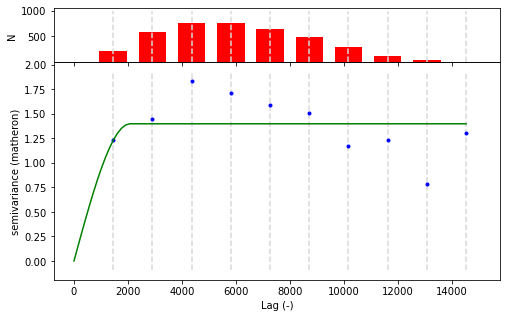

In [2]:
# [2]
# benötigte Packages einladen
from skgstat import Variogram

# Variogrammobjekt erzeugen
Var = Variogram(data[['Rechtswert', 'Hochwert']].values, data.GWT)

# Variogrammobjekt plotten
Var.plot();

Am Histogram ist nun zu erkennen, dass Werte im Bereich von Lags über 8.000 nicht gut durch die Daten unterstützt werden. Daher sollten wir die Größe der berücksichtigten Lags entsprechend reduzieren: `V-Objekt.maxlag = 8000`. 

Da wir über 90 Messwerte haben können wir außerdem die Anzahl der Lag-Klassen etwas erhöhen: `V-Objekt.n_lags=15`. 

Lasst Euch anschließend das veränderte Variogram anzeigen und vergleicht es mit dem von oben. 

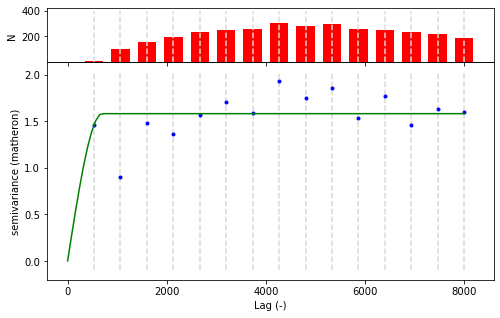

In [3]:
# [3]
# maxlag und nlag des Variogrammobjekts anpassen
Var.maxlag = 8000
Var.n_lags = 15

# Variogrammobjekt plotten
Var.plot(show=False);

Diese Anpassung sieht nun allerdings besonders im Bereich der kurzen Distanzen (niedriege Lags) visuell nicht sehr überzeugend aus. Gerade dieser Bereich ist jedoch wichtig für die Bestimmung der Gewichte für das Kriging. 

Wenn nicht anders definiert nimmt `skgstat.Variogram()` ein sphärisches Varianzmodell an. Erstellt neben diesem noch zwei weitere Variogrammobjekte mit anderen Modellen ("exponential" und "gaussian") über die Angabe von `V-Objekt.model ='name'` (die anderen Angaben zu den Modellen von oben bleiben davon unbeeinflusst). 

Die Variogram-Klasse hat außerdem eine eingebaute Funktionalität um den RMSE (`rmse`) der Anpassung zu berechnen: `V-Objekt.rmse`. Lasst Euch damit die Fehler der Anpassungen ausgeben.

Plottet die verschiedenen Anpassungen zum Vergleich nebeneinander (`matplotlib.subplots()`) und vergleicht den visuellen Eindruck der Anpassung mit den berechneten RMSE-Werten. 

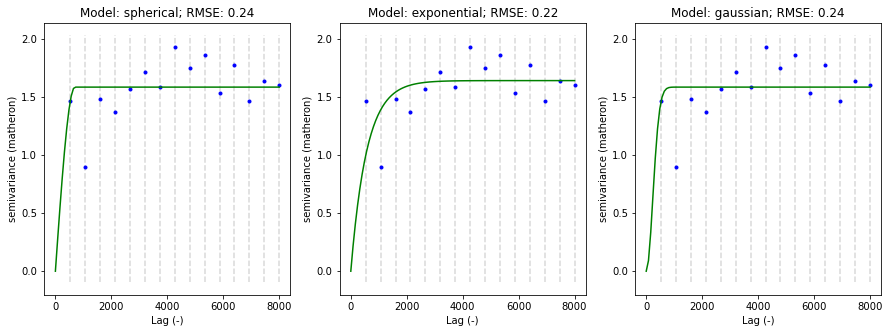

In [4]:
# [4]
# benötigte Packages einladen 
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
Var.model = 'spherical'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('spherical', Var.rmse))

ax = axs[1]
Var.model = 'exponential'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('exponential', Var.rmse))

ax = axs[2]
Var.model = 'gaussian'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('gaussian', Var.rmse))
plt.show()

Wählt nun das passenste Variogramm-Modell aus und führt ein Ordinary Kriging (`skgstat.OrdinaryKriging()`) durch. Dafür sind folgende Schritte nötig: 

- für das Variogramm-Objekt von oben das gewünschte Modell angeben (`V-Objekt.model ='name'`). 

- Interpolationsobjekt definieren: `OrdinaryKriging(Variogramm, min_points=2, max_points=8)`. Die Auswahl der minimal und maximal berücksichtigten Anzahl an Nachbarpunkten orientiert sich an Anzahl und Abstand zwischen den Messpunkten (eine Art Optimierungsparameter)

- gleichmäßiges Grid mit den zu interpolierenden Koordinaten erstellen (siehe letzte Übung)

- Die `.transform()` Funktion auf das Interpolationsobjekt anwenden: Die x- und y-Koordinaten werden dabei als einzelne 1D Numpy Arrays benötigt. Erzeugen könnt Ihr diese z.B. über `array.flatten()` 

- Ergebnis mit `plt.imshow()` visualisieren. Dafür müsst Ihr den eben erzeugten 1-DArray mit den interpolierten Werten wieder umstruktieren, d.h. in seine ursprüngliche Form bringen, z.B. mit `array.reshape(dimensions)`

- plottet auch die Lage der Messpunkte zu dem interpolierten Raster (siehe letzte Übung).

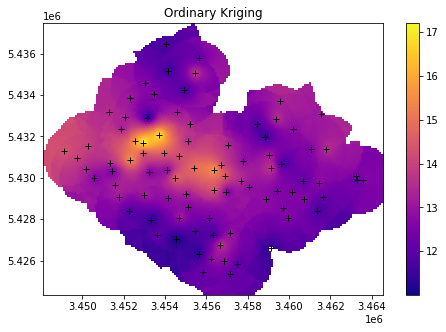

In [5]:
# [5]
# benötigte Packages einladen
from skgstat import OrdinaryKriging
import numpy as np

# Variogramm-Model für das Variogrammobjekt von oben angeben
Var.model = 'exponential'

# Interpolationsobjekt erzeugen
ok = OrdinaryKriging(Var, min_points=2, max_points=8)

# Grid für die Interpolation erstellen
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]
grid_x, grid_y = np.mgrid[x_min:x_max:100, y_min:y_max:100]

# 1D Arrays daraus erzeugen und transform anwenden
field = ok.transform(grid_x.flatten(), grid_y.flatten())

# die mit transform erzeugte Variable auf 2D umstrukturieren 
field = field.reshape(grid_x.shape)

# Abbildung mit imshow erstellen
plt.figure(figsize=(8, 5))
plt.imshow(field.T, origin='lower', extent=extent, cmap='plasma')
plt.title('Ordinary Kriging')
plt.plot(data.Rechtswert, data.Hochwert, '+k')
plt.colorbar()
plt.show()

## Ende

### Referenzen

Menberg et al. (2013): Long-term evolution of anthropogenic heat fluxes into a subsurface urban heat island, Environ. Sci. Technol. 47(17) (2013) 9747-9755

https://mmaelicke.github.io/scikit-gstat/tutorials/01_getting_started.html